# Enoncé

Bienvenue dans le TP guidé de Keras. Vous allez ici devoir faire la compétition [Chien VS Chat de Kaggle](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/leaderboard). Vous aurez pour cela toute la matinée.

Ce TP a été réalisé avec la librairie Keras qui va vous permettre de créer et d'entrainer des réseaux de neurones facilement. 
L'objectif de ce TP est de vous montrer un pipeline complet d'un projet de deep learning( donc de machine learning). Ce pipeline est systématiquement le même, vous pourrez ainsi vous appuyer dessus méthodologiquement.

Pour rappel le pipeline théorique d'un projet de DL est le suivant:


# Pipeline 

1. Initialisation du problème:
    - identifier le type de tâches (supervisé / non supervisé)
    - la nature des données (images, sons, textes, etc.)
    - récupérer les données
    

2. Exploration des données:
    - Visualisation des données afin de bien les comprendre (graphiques, affichage des données)
    - Distribution de la variable cible (si classification regarder si les classes sont bien équilibrées)
    
    
3. Séparation du jeu en test / train (pour kaggle c'est déjà le cas) / validation
    - Faire en sorte que les donénes de tests représentent bien les données d'entraînement.
    
    
4. Préparation des données pour une future modélisation *
    - Normaliser les données
    - Créer un accesseur python pour pouvoir facilement manipuler les données
    - Numériser les données
    
    
5. Modélisation et entraînement *
    - Choix et implémentation d'une experience. Celle-ci décrit une architecture et des hyper-paramètres
    - Implémentation d'une architecture (choix tensorflow vs keras en fonction)
    
   
6. Evaluation du modèle: *
    - Utiliser au moins une métrique (kaggle vous en propose une)
    
*Itérations



En s'appuyant sur ce pipeline, nous allons faire plusieurs tentatives sur le challenge kaggle.

Bonne chance !

----

# TP : Modélisation de pipeline 

## 1. Initialisation du problème

Vous commencez par lire toutes informations que vous pouvez trouver sur le problème. Ici , sur kaggle. Vous pouvez alors récupérer les données.

On importe les librairies que l'on souhaite uliser. On pourra revenir au fur et à mesure sur cette cellule.


In [1]:
import os, random
import datetime
import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import np_utils
from keras import backend, regularizers

Using TensorFlow backend.


## Import Data

### Images

#### Import

On définit les constantes pour gérer notre projet

In [2]:
TRAIN_DIR = 'datasets/train/smallTrain/'
TEST_DIR = 'datasets/smallTest/'

# la shape de nos images
ROWS = 64 
COLS = 64
CHANNELS = 3

train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)]
test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]

On définit des fonctions utilitaires qui vont nous permettre d'accéder facilement aux données :

In [3]:
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
    """
    Cette fonction nous permet de charger les images dans un objet numpy.
    """
    count = len(images)
    # On initialise la matrice de sortie
    data = np.ndarray((count,ROWS, COLS, CHANNELS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image # nos données sont de la forme (64, 64, 3)
        if i%250 == 0: 
            print('Processed {} of {}'.format(i, count))
    
    return data


In [4]:
train = prep_data(train_images)
test = prep_data(test_images)

print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

Processed 0 of 252
Processed 250 of 252
Processed 0 of 216
Train shape: (252, 64, 64, 3)
Test shape: (216, 64, 64, 3)


## 2. Exploration des données



### Labels

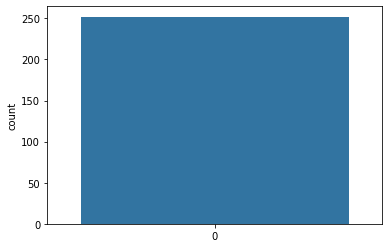

In [5]:
labels = []
for i in train_images:
    if 'dog' in i:
        labels.append(1)
    else:
        labels.append(0)

sns.countplot(labels)

### Plot

In [6]:
def plot_image(idx):
    print("Label : " + str(labels[idx]))
    plt.imshow(train[idx])
    plt.show()

In [7]:
ramdom_samples = np.random.randint(0, len(train), 5)

Label : 0


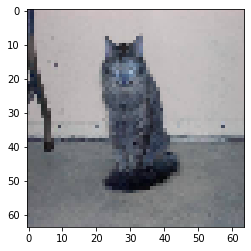

Label : 0


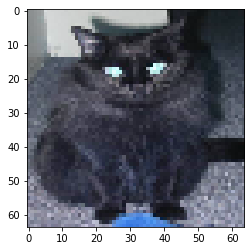

Label : 0


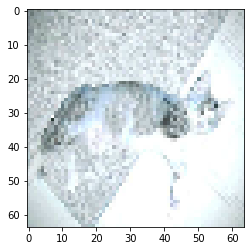

Label : 0


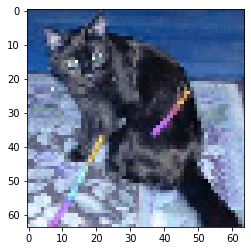

Label : 0


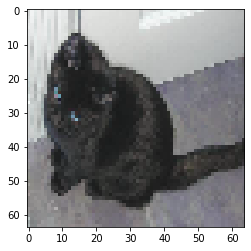

In [8]:
for i in ramdom_samples:
    plot_image(i)

# 3. Préparation 

On suit les étapes du pipeline et on prépare les données

### Normalization

In [9]:
def normalize_images(images):
    #data = np.full((len(images),64,64,3), 255)
    rescaled_images = images/255
    return rescaled_images

scaled_train = normalize_images(train)
scaled_test = normalize_images(test)

## 4. Modelisation

Nous sommes face à un problème de classification d'images. Notre choix d'architecture se dirige naturellement vers une architecture de type CNN. On commence par une architecture très simple pour vérifier le fonctionnement du code.
Pour ce faire on va s'aider d'une fonction "model" qui va nous retourner une architecture keras Sequential. A l'interieur de cette fonction on va désigner notre model (architecture + loss)

In [10]:
def model():
    backend.clear_session()
    
    # On créé un model Sequential de Keras à l'aide de Sequential()
    model = Sequential()
    
    ###### Architecture ######
    ##### Conv Layer 1 #####
    model.add(Convolution2D(filters=2,
                            kernel_size=(3, 3), 
                            strides=(1, 1),
                            padding='same', 
                            input_shape=(ROWS, COLS, CHANNELS), 
                            activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=((2, 2))))
    
    
    ##### FeedForward #####
    ## Hidden 1
    
    #On flatten notre sortie à l'aide de Flatten()
    model.add(Flatten())
    
    model.add(Dense(4, activation='relu'))
    
    model.add(Dropout(0,5))
    
    ## Output
    # Nous devons obtenir une sortie binaire. Pour ce faire utiliser la bonne fonction d'activation :
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    ###### Training ######
    # Sélectionnez une fonction de cout cohérante avec notre problématique
    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    
    return model   

On va maintenant créer une fonction "train_model" qui va nous permettre d'entrainer un modèle:

In [11]:
def train_model(model, scaled_train, nb_epoch, batch_size, tensorboard_callback, checkpoint):
    model.fit(scaled_train, labels, batch_size=batch_size, nb_epoch=nb_epoch,
              validation_split=0.2,  verbose=1, shuffle=True, callbacks=[tensorboard_callback, checkpoint])

## Training

On définit nos hyper paramètres

In [12]:
nb_epoch = 2
batch_size = 64

On log à chaque Epoch la loss et l'accuracy pour le train et la validation (avec comme nom la date ci-dessous)

In [13]:
model_name = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
tensorboard_callback = TensorBoard(log_dir='./graphs/' + model_name, write_graph=True, write_images=True)

On sauvegarde le model à chaque Epoch si on a eu une amélioration sur l'accuracy du jeu de validation

In [14]:
os.makedirs("Models", exist_ok=True)
filepath= "Models/" + model_name + "weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [15]:
first_model = model()
# On affiche l'architecture que l'on vient d'instantier
first_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 2)         56        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 2)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1922)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 7692      
_________________________________________________________________
dropout_1 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
_________________________________________________________________
activation_1 (Activation)    (None, 1)                

In [ ]:
#On va pouvoir maintenant entraîner le modèle : 
train_model(first_model, scaled_train, nb_epoch, batch_size, tensorboard_callback, checkpoint)

## Prédiction

Maintenant que notre modèle est entrainé on souhaite l'utiliser pour faire des prédictions sur le jeu de test, c'est notre objectif. On va utiliser pour cela la fonction predict de notre objet model, qui prend en paramètre des données, ici notre jeu de test que l'on va souhaiter évaluer

In [ ]:
predictions = first_model.predict(scaled_test, verbose=1)

On formate les données pour pouvoir générer un fichier csv de réponses pour kaggle

In [ ]:
final_df = pd.concat([
    pd.Series(range(1, len(test)+1), name='id'),
    pd.Series(predictions[:, 0], name='label')
], axis=1)

In [ ]:
final_df.to_csv('test_submission.csv', index=False)

## Affichage de la prédiction

In [ ]:
random_samples_test = np.random.randint(0, len(scaled_test), 40)

In [ ]:
for i in random_samples_test:
    if predictions[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1-predictions[i][0]))
        
    plt.imshow(scaled_test[i])
    plt.show()

# A vous de jouer ! 

Maintenant que nous avons un pipeine complet c'est à vous de travailler d'améliorer le modèle pour avoir un meilleur score ! Essayez ce que l'on a vu en cours :
différentes architectures , transfert learning, diagnostiquer votre modèle à l'aide de tensorboard pour savoir si vous faites du transfert learning, etc.

## Vous devrez :

En bas de cette cellule lister toutes vos modifications pour quel score kaggle vous avez obtenu